# 1. 개요 
개요 및 import와 변수 등에 대한 설정 부분

In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16, DenseNet201
from keras import models
from keras import layers
from keras import optimizers
from enum import Enum

In [2]:
print('케라스 버전 : {}'.format(keras.__version__))
print('텐서플로 버전 : {}'.format(tf.__version__))

케라스 버전 : 2.4.0
텐서플로 버전 : 2.3.0


In [3]:
# 테스트할 모델 유형을 enum 타입으로 정리.
class ModelType(Enum):
    ALL = 0
    CNN = 1
    VGG16 = 2
    DENSENET201 = 3

In [4]:
# 코드변수들 설정 (코드의 IF 문 같은데서 이용하는 목적임. 훈련,학습과는 관계없음)
IMAGE_UNZIP_WITH_COPY = False

# 검증용, 테스트용 비율
VALID_FILE_RATE = 0.2  # 검증용 파일 비율
TEST_FILE_RATE = 0.2  # 테스트용 파일 비율

# 이미지 가로,세로
IMAGE_WIDTH=150
IMAGE_HEIGHT=150

# 사용할 모델 유형 지정.
MODEL_TYPE = ModelType.DENSENET201

# 2. 이미지 데이터셋 의 처리

캐글의 이미지 데이터셋의 압축을 해제하고, 폴더 별로 구성합니다. 

`ImageDataGenerator`를 이용하기 위해서는 train, valid(validation)으로 나눌 필요가 있습니다. ImageDataGenerator의 'validation_split'을 이용할 경우에는 나누지 않아도 됩니다. (단지 이 경우에는 검증값도 이미지가 변형될 수 있음에 주의)

## 2.1. 압축 해제

1. 최상위 디렉토리 생성. 'train' 디렉토리 생성.
2. `extract`에 원본 소스 이미지 압축 풀기
  - `/input/dogs-vs-cats/` 의 'train.zip'파일을 `/output/kaggle/working/extract` 으로 압축해제 합니다.

In [5]:
# zip 으로 묶여있는 이미지셋 압축 해제
if IMAGE_UNZIP_WITH_COPY : 
    # 폴더가 이미 존재할 경우에는 삭제 후 다시 압축 해제 (그냥 혹시 몰라서 넣는 코드)
    if os.path.exists('./extract'):
        shutil.rmtree('./extract')

    # train.zip압축 해제 (/input/dogs-vs-cats/train.zip)(/output/kaggle/working/train/extract)
    with zipfile.ZipFile("../input/dogs-vs-cats/train.zip", 'r') as zip_ref:
        zip_ref.extractall("./extract")
        
    # test1.zip압축 해제 (/output/kaggle/working)
    #with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", 'r') as zip_ref:
    #    zip_ref.extractall("./")

In [6]:
# 디렉토리 경로 등을 설정할 변수
dirs = {}
dirs['base'] = './train'
dirs['extract_train'] = './extract/train'
dirs['extract_train_trash'] = os.path.join(dirs['extract_train'], 'trash')
dirs['train'] = os.path.join(dirs['base'], 'train')
dirs['valid'] = os.path.join(dirs['base'], 'valid')
dirs['test'] = os.path.join(dirs['base'], 'test')
train_dir = dirs['train']
valid_dir = dirs['valid']

# 학습용 cats, dogs 
dirs['train_cats'] = os.path.join(dirs['train'], 'cats')
dirs['train_dogs'] = os.path.join(dirs['train'], 'dogs')

# 검증용 cats, dogs
dirs['valid_cats'] = os.path.join(dirs['valid'], 'cats')
dirs['valid_dogs'] = os.path.join(dirs['valid'], 'dogs')

# 테스트용 cats, dogs
dirs['test_cats'] = os.path.join(dirs['test'], 'cats')
dirs['test_dogs'] = os.path.join(dirs['test'], 'dogs')

In [7]:
print("전체 이미지 수 : {}".format(
    len([f for f in os.listdir(dirs['extract_train']) if os.path.isfile(os.path.join(dirs['extract_train'], f))])))

print("고양이 이미지 수 : {}".format(
    len([f for f in os.listdir(dirs['extract_train']) if os.path.isfile(os.path.join(dirs['extract_train'], f)) and 'cat' in f])))

print("강아지 이미지 수 : {}".format(
    len([f for f in os.listdir(dirs['extract_train']) if os.path.isfile(os.path.join(dirs['extract_train'], f)) and 'dog' in f])))

전체 이미지 수 : 24918
고양이 이미지 수 : 12455
강아지 이미지 수 : 12463


## 2.2. 학습, 검증 등을 위한 폴더 생성

In [8]:
if IMAGE_UNZIP_WITH_COPY : 
    # 폴더 및 데이터 재구성
    if os.path.exists(dirs['base']):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
        shutil.rmtree(dirs['base'])   # 이 코드는 책에 포함되어 있지 않습니다.
    os.mkdir(dirs['base'])

    # train, valid, test 디렉토리 구성
    os.mkdir(dirs['train'])
    os.mkdir(dirs['valid'])
    os.mkdir(dirs['test'])
    
    # 훈련용 cats, dogs 디렉토리
    os.mkdir(dirs['train_cats'])
    os.mkdir(dirs['train_dogs'])
    
    # 검증용 cats, dogs 디렉토리
    os.mkdir(dirs['valid_cats'])
    os.mkdir(dirs['valid_dogs'])

    # 테스트용 cats, dogs 디렉토리
    os.mkdir(dirs['test_dogs'])
    os.mkdir(dirs['test_cats'])

## 2.3. 애매한 이미지 파일 제거
이 쯤에서 애매하거나 불필요한 이미지파일들은 제거.
1. 고양이도 개도 아닌 사진
2. 사진이 아닌 그림, 삽화
3. 개와 고양이가 둘 다 있는 사진 제외 (학습시 안 좋을 듯 해서 제외)
4. 등만 보인다거나 배만 보인다거나 하는 경우 제외
5. 신생아 수준의 사진

참조 링크
* https://thedatafrog.com/en/articles/dogs-vs-cats/#Pet-cleaning:-improving-the-dataset-quality

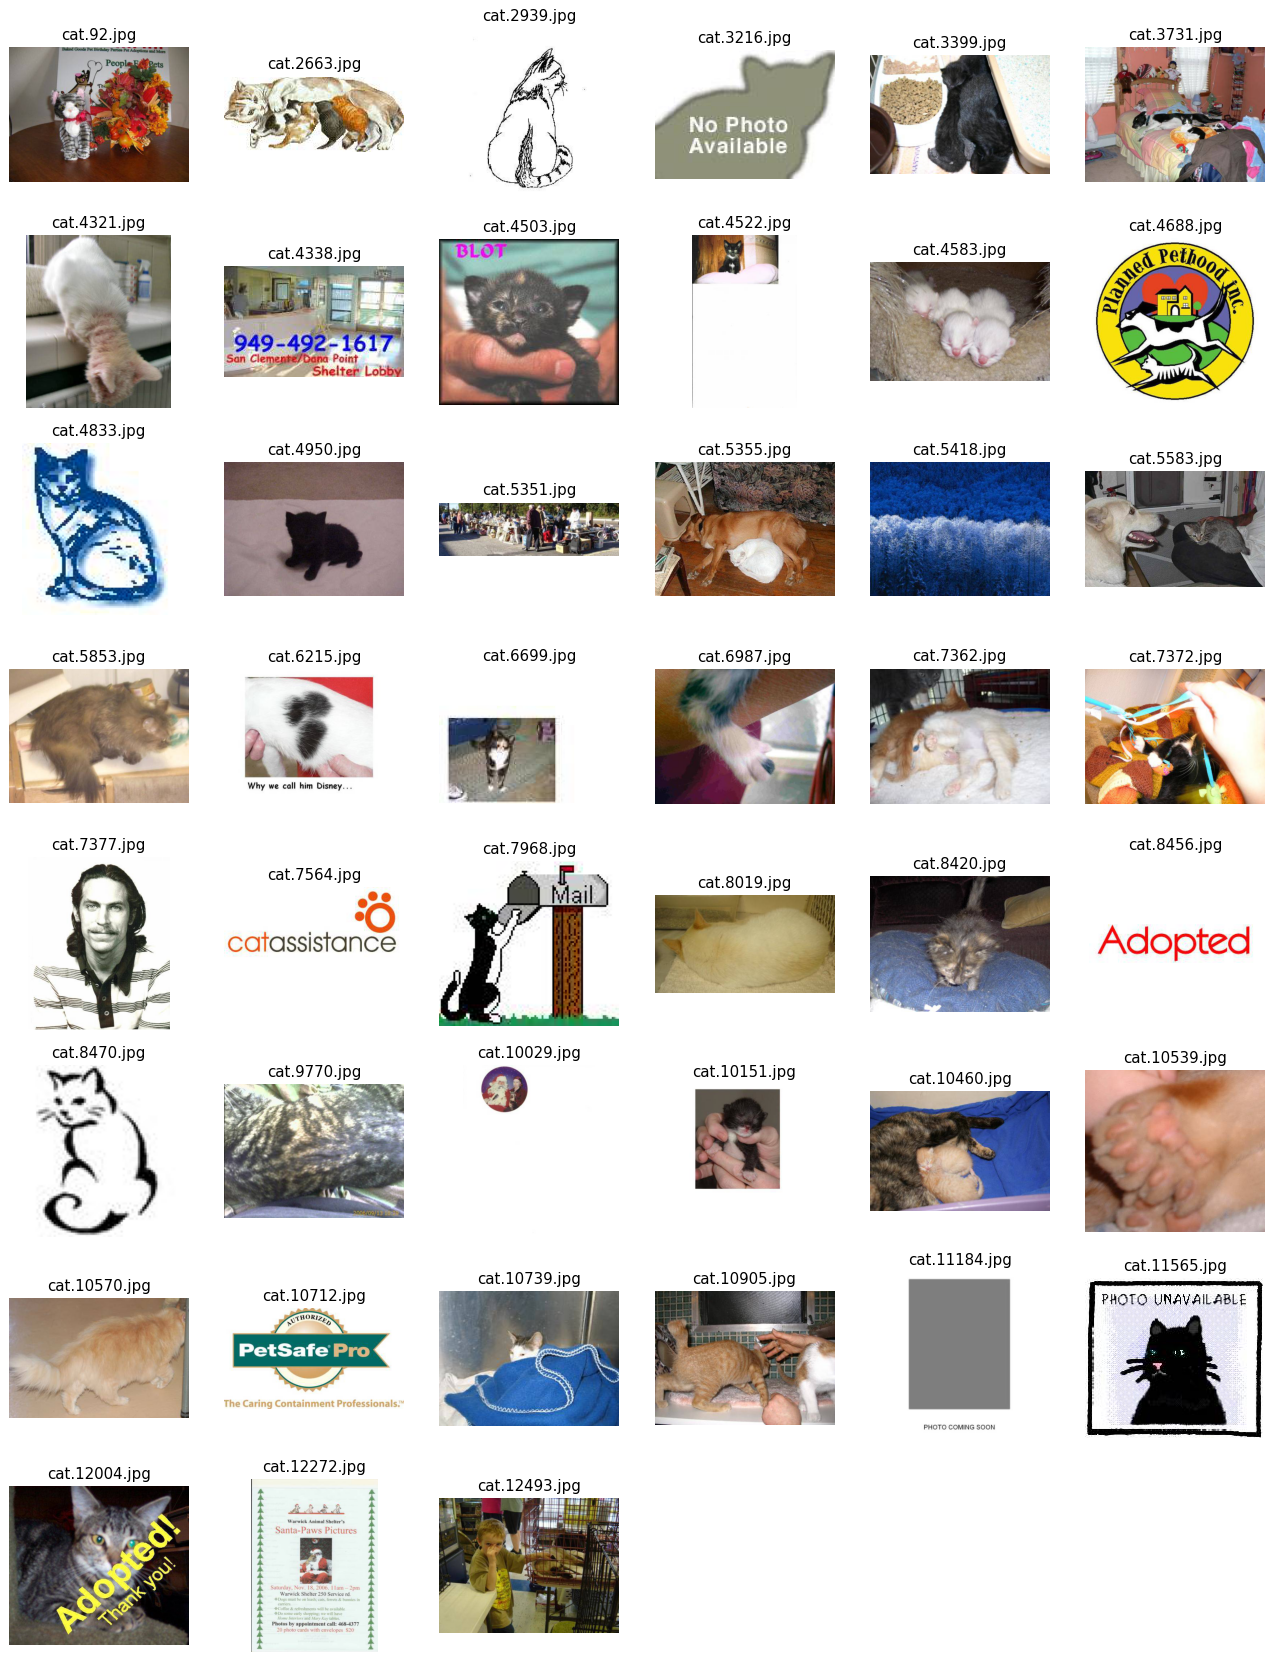

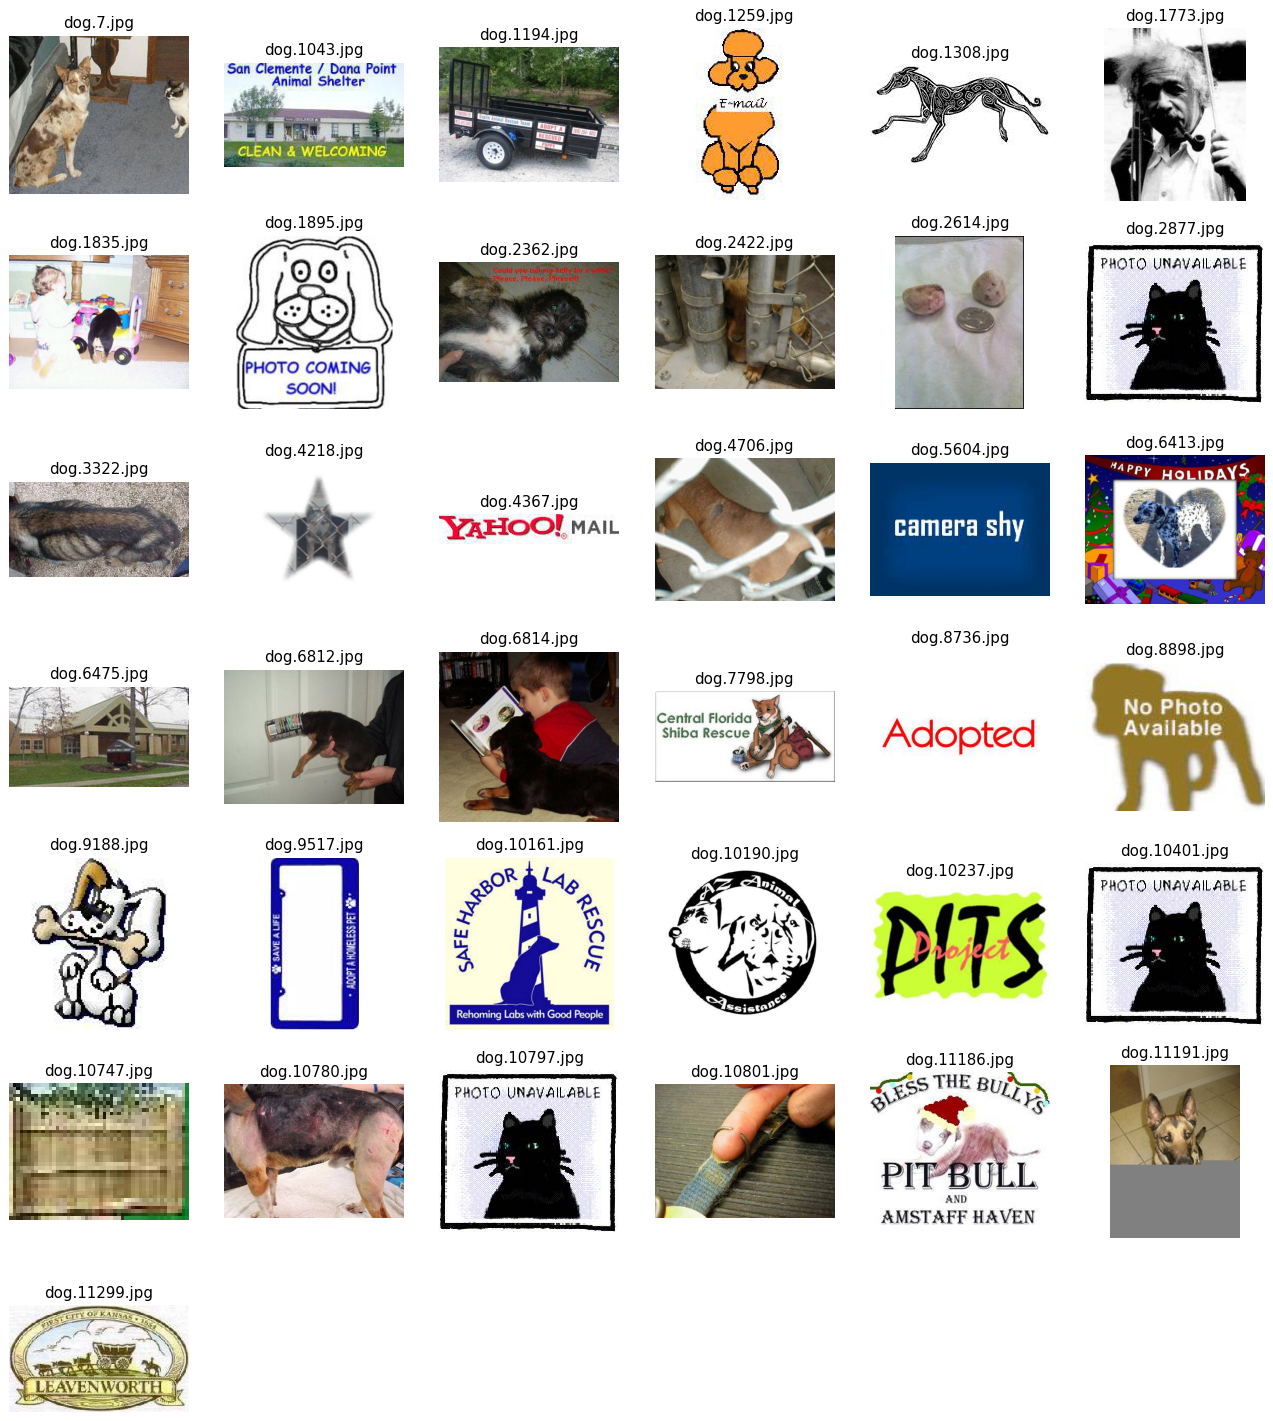

In [9]:
bad_cat_ids = [92, 2663, 2939, 3216, 3399, 3731, 4321, 4338, 4503, 4522, 4583, 4688, 4833, 4950,
               5351, 5355, 5418, 5583, 5853, 6215, 6699, 6987, 7362, 7372, 7377, 7564, 7968, 8019, 8420, 8456,
               8470, 9770, 10029, 10151, 10460, 10539, 10570, 10712, 10739, 10905, 11184, 
               11565, 12004, 12272, 12493]

bad_dog_ids = [7, 1043, 1194, 1259, 1308, 1773, 1835, 1895, 2362, 2422,
               2614, 2877, 3322, 4218, 4367, 4706, 5604, 6413, 6475, 6812, 6814,
               7798, 8736, 8898, 9188, 9517, 
               10161, 10190, 10237, 10401, 10747, 10780,
               10797, 10801, 11186, 11191, 11299]

# 이미지 화면에서 확인하기
def plot_images(cate, ids):
    ncols, nrows = 6, 10
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    
    for i, img_id in enumerate(ids):
        if IMAGE_UNZIP_WITH_COPY : 
            dirname = dirs['extract_train']
        else :
            dirname = dirs['extract_train_trash']
        filename = '{}.{}.jpg'.format(cate,img_id)
        img = plt.imread(os.path.join(dirname, filename))
        
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.title(str(filename))
        plt.axis('off')


bad_cats = plot_images('cat', bad_cat_ids)
bad_dogs = plot_images('dog', bad_dog_ids)

In [10]:
# 제거의 기능을 담당하는 함수
def cleanup(cate, ids):
    oldpwd = os.getcwd()
   
    trash_dir = dirs['extract_train_trash']
    if not os.path.exists(trash_dir):
        os.mkdir(trash_dir)
    
    for id in ids:
        filename = '{cate}.{id}.jpg'.format(cate=cate,id=id)
        src = os.path.join(dirs['extract_train'], filename)
        shutil.move(src, trash_dir)

# 제거 실행
if IMAGE_UNZIP_WITH_COPY : 
    cleanup('cat', bad_cat_ids)
    cleanup('dog', bad_dog_ids)

## 2.4. 각 폴더별로 이미지 나눠서 복사
각각 train, validation, test 폴더로 나눠서 구성한다. 
전체 이미지의 갯수는 25,000이고, 고양이 강아지 각각 반으로 나누면 12,500 개씩 있을 것이고. 60%, 20%, 20% 으로 구성한다면. (참고 https://ebbnflow.tistory.com/125)

예상치 (빠진 것들이 있으므로 이보다 적음)
* train - 7,500
* validation - 2,500
* test - 2,500 

In [11]:
# 비율별로 추출할 번호를 계산
cat_count_total = 12500
dog_count_total = 12500

cat_count_valid = int(cat_count_total * VALID_FILE_RATE)
cat_count_test = int(cat_count_total * TEST_FILE_RATE)
cat_count_train = cat_count_total - cat_count_valid - cat_count_test

dog_count_valid = int(dog_count_total * VALID_FILE_RATE)
dog_count_test = int(dog_count_total * TEST_FILE_RATE)
dog_count_train = dog_count_total - dog_count_valid - dog_count_test

print("cats : total {} / train {} / valid {} / test {}".format(cat_count_total, cat_count_train, cat_count_valid, cat_count_test))
print("dogs : total {} / train {} / valid {} / test {}".format(dog_count_total, dog_count_train, dog_count_valid, dog_count_test))

cats : total 12500 / train 7500 / valid 2500 / test 2500
dogs : total 12500 / train 7500 / valid 2500 / test 2500


In [12]:
# 파일명으로 구분하여 복사를 실행하는 함수
def partialCopyImages(cate, start, end, origin, dest) :
    files = ['{}.{}.jpg'.format(cate, i) for i in range(start, end)]
    for filename in files:
        src = os.path.join(origin, filename)
        dst = os.path.join(dest, filename)
        if IMAGE_UNZIP_WITH_COPY : 
            if os.path.isfile(src):
                shutil.copyfile(src, dst)

if IMAGE_UNZIP_WITH_COPY : 
    origin_dir = dirs['extract_train']
    
    # 고양이 [학습용, 검증용, 테스트용] 복사
    partialCopyImages('cat', 0, cat_count_train, origin_dir, dirs['train_cats'])
    partialCopyImages('cat', cat_count_train, cat_count_train+cat_count_valid, origin_dir, dirs['valid_cats'])
    partialCopyImages('cat', cat_count_train+cat_count_valid, cat_count_total, origin_dir, dirs['test_cats'])

    # 강아지 [학습용, 검증용, 테스트용] 복사
    partialCopyImages('dog', 0, dog_count_train, origin_dir, dirs['train_dogs'])
    partialCopyImages('dog', dog_count_train, dog_count_train+dog_count_valid, origin_dir, dirs['valid_dogs'])
    partialCopyImages('dog', dog_count_train+dog_count_valid, dog_count_total, origin_dir, dirs['test_dogs'])

In [13]:
# 결과 확인
print('고양이 이미지 [학습용]: ', len(os.listdir(dirs['train_cats'])))
print('고양이 이미지 [검증용]: ', len(os.listdir(dirs['valid_cats'])))
print('고양이 이미지 [테스트용] ', len(os.listdir(dirs['test_cats'])))
print('--------------------------------')
print('강아지 이미지 [학습용] ', len(os.listdir(dirs['train_dogs'])))
print('강아지 이미지 [검증용] ', len(os.listdir(dirs['valid_dogs'])))
print('강앙지 이미지 [테스트용] ', len(os.listdir(dirs['test_dogs'])))

고양이 이미지 [학습용]:  7475
고양이 이미지 [검증용]:  2493
고양이 이미지 [테스트용]  2487
--------------------------------
강아지 이미지 [학습용]  7479
강아지 이미지 [검증용]  2495
강앙지 이미지 [테스트용]  2489


# 3. 모델 종류별

# 3.1. CNN 모델
간단히 작성한 CNN 모델로 어떤 성능을 나타내는지 확인해보자.

## 3.1.1. 데이터 전처리 (CNN)

In [ ]:
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    # ------------------------
    # 훈련용 데이터 전처리
    # ------------------------
    train_dategen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    # batch_size = 128
    batch_size = 20

    train_generator = train_dategen.flow_from_directory(
        train_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')


    # ------------------------
    # 검증용 데이터 전처리
    # ------------------------
    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')

    # ------------------------
    # 데이터 형태 확인
    # ------------------------
    for data_batch, labels_batch in train_generator:
        print('Data batch shape:', data_batch.shape)
        print('Labels batch shape:', labels_batch.shape)
        break;

## 3.1.2. 모델 생성 (CNN)

In [ ]:
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
=================================================================
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
```

## 3.1.3. 모델 학습 (CNN)

In [ ]:
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.Adamax(lr=0.001),
             metrics=['acc'])
    
    # validation_steps=50,
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs = 50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)]
    )

```
Epoch 1/50
748/748 [==============================] - 122s 162ms/step - loss: 0.4302 - acc: 0.8035 - val_loss: 0.3871 - val_acc: 0.8356
Epoch 2/50
748/748 [==============================] - 122s 163ms/step - loss: 0.4033 - acc: 0.8199 - val_loss: 0.3175 - val_acc: 0.8649
Epoch 3/50
748/748 [==============================] - 125s 167ms/step - loss: 0.3677 - acc: 0.8354 - val_loss: 0.3125 - val_acc: 0.8609
Epoch 4/50
748/748 [==============================] - 126s 169ms/step - loss: 0.3475 - acc: 0.8489 - val_loss: 0.2795 - val_acc: 0.8801
Epoch 5/50
748/748 [==============================] - 125s 167ms/step - loss: 0.3208 - acc: 0.8599 - val_loss: 0.2689 - val_acc: 0.8811
Epoch 6/50
748/748 [==============================] - 125s 168ms/step - loss: 0.3156 - acc: 0.8671 - val_loss: 0.3007 - val_acc: 0.8681
Epoch 7/50
748/748 [==============================] - 125s 168ms/step - loss: 0.2953 - acc: 0.8728 - val_loss: 0.3719 - val_acc: 0.8448
Epoch 8/50
748/748 [==============================] - 124s 166ms/step - loss: 0.2937 - acc: 0.8746 - val_loss: 0.2497 - val_acc: 0.8887
Epoch 9/50
748/748 [==============================] - 125s 168ms/step - loss: 0.2827 - acc: 0.8814 - val_loss: 0.2377 - val_acc: 0.9018
Epoch 10/50
748/748 [==============================] - 124s 166ms/step - loss: 0.2791 - acc: 0.8765 - val_loss: 0.2589 - val_acc: 0.8879
Epoch 11/50
748/748 [==============================] - 125s 168ms/step - loss: 0.2605 - acc: 0.8894 - val_loss: 0.2760 - val_acc: 0.8871
Epoch 12/50
748/748 [==============================] - 124s 166ms/step - loss: 0.2547 - acc: 0.8893 - val_loss: 0.2268 - val_acc: 0.8986
Epoch 13/50
748/748 [==============================] - 123s 164ms/step - loss: 0.2581 - acc: 0.8878 - val_loss: 0.2008 - val_acc: 0.9146
Epoch 14/50
748/748 [==============================] - 122s 163ms/step - loss: 0.2307 - acc: 0.9026 - val_loss: 0.2420 - val_acc: 0.8988
Epoch 15/50
748/748 [==============================] - 121s 162ms/step - loss: 0.2309 - acc: 0.9018 - val_loss: 0.2103 - val_acc: 0.9164
Epoch 16/50
748/748 [==============================] - 121s 161ms/step - loss: 0.2251 - acc: 0.9058 - val_loss: 0.1971 - val_acc: 0.9170
Epoch 17/50
748/748 [==============================] - 120s 160ms/step - loss: 0.2257 - acc: 0.9035 - val_loss: 0.2086 - val_acc: 0.9120
Epoch 18/50
748/748 [==============================] - 119s 159ms/step - loss: 0.2242 - acc: 0.9040 - val_loss: 0.2051 - val_acc: 0.9140
Epoch 19/50
748/748 [==============================] - 120s 160ms/step - loss: 0.2099 - acc: 0.9099 - val_loss: 0.1685 - val_acc: 0.9290
Epoch 20/50
748/748 [==============================] - 119s 159ms/step - loss: 0.2158 - acc: 0.9114 - val_loss: 0.2015 - val_acc: 0.9168
Epoch 21/50
748/748 [==============================] - 120s 160ms/step - loss: 0.2094 - acc: 0.9150 - val_loss: 0.1732 - val_acc: 0.9292
Epoch 22/50
748/748 [==============================] - 119s 160ms/step - loss: 0.1995 - acc: 0.9132 - val_loss: 0.1956 - val_acc: 0.9174
Epoch 23/50
748/748 [==============================] - 119s 159ms/step - loss: 0.2005 - acc: 0.9165 - val_loss: 0.1935 - val_acc: 0.9178
Epoch 24/50
748/748 [==============================] - 119s 159ms/step - loss: 0.1863 - acc: 0.9190 - val_loss: 0.1617 - val_acc: 0.9360
Epoch 25/50
748/748 [==============================] - 121s 161ms/step - loss: 0.1830 - acc: 0.9236 - val_loss: 0.2323 - val_acc: 0.9022
Epoch 26/50
748/748 [==============================] - 121s 162ms/step - loss: 0.1759 - acc: 0.9266 - val_loss: 0.1771 - val_acc: 0.9276
Epoch 27/50
748/748 [==============================] - 121s 162ms/step - loss: 0.1853 - acc: 0.9217 - val_loss: 0.1882 - val_acc: 0.9194
Epoch 28/50
748/748 [==============================] - 124s 166ms/step - loss: 0.1817 - acc: 0.9253 - val_loss: 0.1614 - val_acc: 0.9328
Epoch 29/50
748/748 [==============================] - 122s 162ms/step - loss: 0.1763 - acc: 0.9275 - val_loss: 0.1654 - val_acc: 0.9324
Epoch 30/50
748/748 [==============================] - 121s 161ms/step - loss: 0.1719 - acc: 0.9290 - val_loss: 0.1851 - val_acc: 0.9246
Epoch 31/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1624 - acc: 0.9348 - val_loss: 0.1693 - val_acc: 0.9340
Epoch 32/50
748/748 [==============================] - 121s 162ms/step - loss: 0.1667 - acc: 0.9291 - val_loss: 0.1540 - val_acc: 0.9356
Epoch 33/50
748/748 [==============================] - 122s 163ms/step - loss: 0.1696 - acc: 0.9313 - val_loss: 0.1947 - val_acc: 0.9166
Epoch 34/50
748/748 [==============================] - 121s 162ms/step - loss: 0.1682 - acc: 0.9293 - val_loss: 0.1864 - val_acc: 0.9238
Epoch 35/50
748/748 [==============================] - 121s 162ms/step - loss: 0.1560 - acc: 0.9360 - val_loss: 0.1445 - val_acc: 0.9419
Epoch 36/50
748/748 [==============================] - 120s 160ms/step - loss: 0.1544 - acc: 0.9338 - val_loss: 0.1589 - val_acc: 0.9344
Epoch 37/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1534 - acc: 0.9366 - val_loss: 0.1798 - val_acc: 0.9296
Epoch 38/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1536 - acc: 0.9368 - val_loss: 0.1869 - val_acc: 0.9282
Epoch 39/50
748/748 [==============================] - 120s 160ms/step - loss: 0.1565 - acc: 0.9355 - val_loss: 0.1475 - val_acc: 0.9387
Epoch 40/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1591 - acc: 0.9355 - val_loss: 0.1677 - val_acc: 0.9381
Epoch 41/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1548 - acc: 0.9386 - val_loss: 0.1349 - val_acc: 0.9441
Epoch 42/50
748/748 [==============================] - 121s 161ms/step - loss: 0.1490 - acc: 0.9413 - val_loss: 0.1504 - val_acc: 0.9368
Epoch 43/50
748/748 [==============================] - 121s 161ms/step - loss: 0.1564 - acc: 0.9353 - val_loss: 0.1577 - val_acc: 0.9360
Epoch 44/50
748/748 [==============================] - 121s 162ms/step - loss: 0.1492 - acc: 0.9385 - val_loss: 0.1455 - val_acc: 0.9397
Epoch 45/50
748/748 [==============================] - 120s 160ms/step - loss: 0.1302 - acc: 0.9469 - val_loss: 0.1809 - val_acc: 0.9264
Epoch 46/50
748/748 [==============================] - 121s 161ms/step - loss: 0.1310 - acc: 0.9476 - val_loss: 0.1589 - val_acc: 0.9372
Epoch 47/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1414 - acc: 0.9452 - val_loss: 0.1493 - val_acc: 0.9370
Epoch 48/50
748/748 [==============================] - 120s 160ms/step - loss: 0.1396 - acc: 0.9456 - val_loss: 0.1548 - val_acc: 0.9368
Epoch 49/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1297 - acc: 0.9465 - val_loss: 0.1580 - val_acc: 0.9389
Epoch 50/50
748/748 [==============================] - 120s 161ms/step - loss: 0.1375 - acc: 0.9448 - val_loss: 0.1340 - val_acc: 0.9501
```

## 3.1.4. 모델 저장 (CNN)

In [ ]:
# 모델 파일 저장하기.
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    model.save('cats_vs_dogs_cnn.h5')

In [ ]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [ ]:
if MODEL_TYPE == ModelType.CNN or MODEL_TYPE == ModelType.ALL:
    plot_history(history, (0.65, 1.))

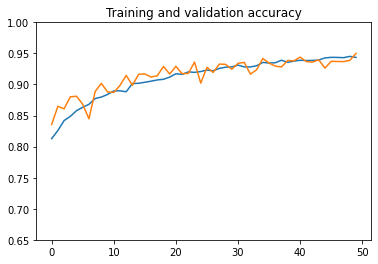
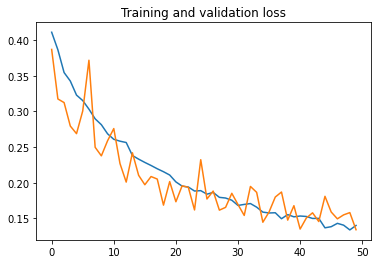


# 3.2. VGG16 모델
vgg16 모델을 이용한 테스트

## 3.2.1. 데이터 전처리 (VGG16)

In [ ]:
if MODEL_TYPE == ModelType.VGG16 or MODEL_TYPE == ModelType.ALL:
    # ------------------------
    # 훈련용 데이터 전처리
    # ------------------------
    train_dategen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    # batch_size = 128
    batch_size = 20

    train_generator = train_dategen.flow_from_directory(
        train_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')


    # ------------------------
    # 검증용 데이터 전처리
    # ------------------------
    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')

## 3.2.2. 모델 생성 (VGG16)

In [ ]:
# VGG Model
if MODEL_TYPE == ModelType.VGG16 or MODEL_TYPE == ModelType.ALL:
    conv_base = VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    # conv_base.summary()
    conv_base.trainable = False

    model_vgg = models.Sequential()
    model_vgg.add(conv_base)
    model_vgg.add(layers.Flatten())
    model_vgg.add(layers.Dense(256, activation='relu'))
    model_vgg.add(layers.Dense(1, activation='sigmoid'))
    model_vgg.summary()

## 3.2.3. 모델 학습 (VGG16)

In [ ]:
if MODEL_TYPE == ModelType.VGG16 or MODEL_TYPE == ModelType.ALL:
    # 컴파일
    model_vgg.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])
    
    # callback 관련
    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor='acc',
            patience=1),
        keras.callbacks.ModelCheckpoint(
            filepath='cats_vs_dogs_vgg16.h5',
            monitor='loss',
            svae_best_only=True)
    ]

    # 학습 시작
    history = model_vgg.fit(
        train_generator,
        steps_per_epoch=15,
        validation_data=valid_generator,
        validation_steps=50,    
        epochs = 10,
        callbacks = callbacks_list)

# 3.3. DenseNet201

In [ ]:
if MODEL_TYPE == ModelType.DENSENET201 or MODEL_TYPE == ModelType.ALL:
    # ------------------------
    # 훈련용 데이터 전처리
    # ------------------------
    train_dategen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    # batch_size = 128
    batch_size = 20

    train_generator = train_dategen.flow_from_directory(
        train_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')


    # ------------------------
    # 검증용 데이터 전처리
    # ------------------------
    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
        batch_size = batch_size,
        class_mode='binary')

    # ------------------------
    # 데이터 형태 확인
    # ------------------------
    for data_batch, labels_batch in train_generator:
        print('Data batch shape:', data_batch.shape)
        print('Labels batch shape:', labels_batch.shape)
        break;

In [ ]:
if MODEL_TYPE == ModelType.DENSENET201 or MODEL_TYPE == ModelType.ALL:
    conv_base = DenseNet201(
                    weights='imagenet',
                    include_top=False,
                    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                    pooling='avg')

    conv_base.trainable = False

    model_densenet201 = models.Sequential()
    model_densenet201.add(conv_base)
    # model_densenet201.add(layers.Flatten())
    model_densenet201.add(layers.Dense(128, activation='relu'))
    model_densenet201.add(layers.Dense(128, activation='relu'))
    model_densenet201.add(layers.Dense(1, activation='sigmoid'))
    model_densenet201.summary()
    
    
    # model_densenet201.compile(
    #    loss='binary_crossentropy',
    #    optimizer='adam',
    #    metrics=['accuracy']
    #)
    model_densenet201.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.Adamax(lr=0.001),
             metrics=['acc'])

```
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_9 (Dense)              (None, 128)               245888    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
=================================================================
Total params: 18,584,513
Trainable params: 262,529
Non-trainable params: 18,321,984
_________________________________________________________________
```

In [ ]:
if MODEL_TYPE == ModelType.DENSENET201 or MODEL_TYPE == ModelType.ALL:
    history = model_densenet201.fit(
        train_generator,
        validation_data=valid_generator,
        epochs = 15,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)]
    )

```
Epoch 1/15
748/748 [==============================] - 136s 169ms/step - loss: 0.1703 - acc: 0.9260 - val_loss: 0.0596 - val_acc: 0.9749
Epoch 2/15
748/748 [==============================] - 123s 165ms/step - loss: 0.1125 - acc: 0.9520 - val_loss: 0.0512 - val_acc: 0.9791
Epoch 3/15
748/748 [==============================] - 123s 164ms/step - loss: 0.1106 - acc: 0.9540 - val_loss: 0.0523 - val_acc: 0.9794
Epoch 4/15
748/748 [==============================] - 123s 164ms/step - loss: 0.1039 - acc: 0.9561 - val_loss: 0.0673 - val_acc: 0.9725
Epoch 5/15
748/748 [==============================] - 123s 165ms/step - loss: 0.1000 - acc: 0.9600 - val_loss: 0.0489 - val_acc: 0.9808
Epoch 6/15
748/748 [==============================] - 123s 164ms/step - loss: 0.0920 - acc: 0.9624 - val_loss: 0.0482 - val_acc: 0.9802
Epoch 7/15
748/748 [==============================] - 124s 165ms/step - loss: 0.0969 - acc: 0.9601 - val_loss: 0.0490 - val_acc: 0.9791
Epoch 8/15
748/748 [==============================] - 123s 165ms/step - loss: 0.0928 - acc: 0.9638 - val_loss: 0.0459 - val_acc: 0.9824
Epoch 9/15
748/748 [==============================] - 124s 165ms/step - loss: 0.0870 - acc: 0.9628 - val_loss: 0.0571 - val_acc: 0.9767
Epoch 10/15
748/748 [==============================] - 126s 169ms/step - loss: 0.0837 - acc: 0.9661 - val_loss: 0.0535 - val_acc: 0.9781
Epoch 11/15
748/748 [==============================] - 124s 165ms/step - loss: 0.0795 - acc: 0.9681 - val_loss: 0.0469 - val_acc: 0.9824
Epoch 12/15
748/748 [==============================] - 124s 166ms/step - loss: 0.0796 - acc: 0.9665 - val_loss: 0.0475 - val_acc: 0.9824
Epoch 13/15
748/748 [==============================] - 124s 165ms/step - loss: 0.0843 - acc: 0.9661 - val_loss: 0.0473 - val_acc: 0.9834
Epoch 14/15
748/748 [==============================] - 128s 170ms/step - loss: 0.0780 - acc: 0.9721 - val_loss: 0.0516 - val_acc: 0.9812
Epoch 15/15
748/748 [==============================] - 124s 165ms/step - loss: 0.0754 - acc: 0.9697 - val_loss: 0.0484 - val_acc: 0.9818
```